Number of clean images: 150
Number of unclean images: 150


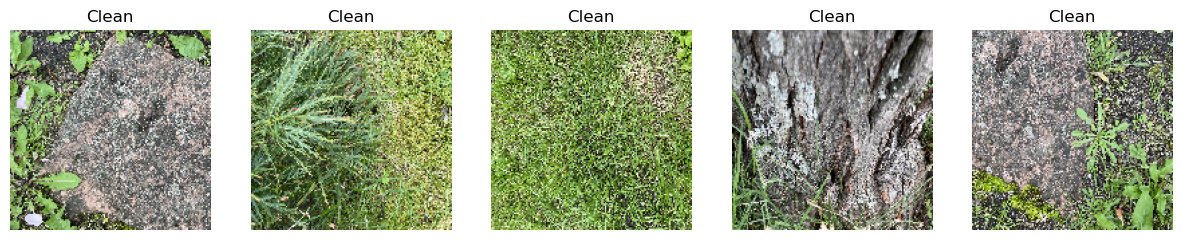

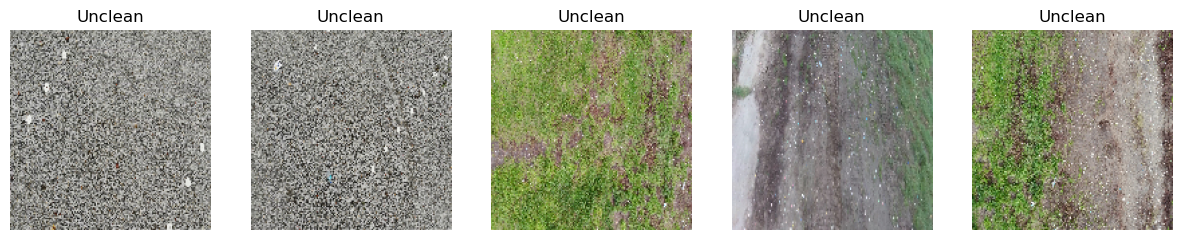

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Define the paths to your data
base_dir = 'C:/Users/user/Downloads/ML image classifier'  # Replace with your actual path
clean_dir = os.path.join(base_dir, 'clean')
unclean_dir = os.path.join(base_dir, 'unclean')

# Check the number of images in each folder
num_clean = len(os.listdir(clean_dir))
num_unclean = len(os.listdir(unclean_dir))

print(f"Number of clean images: {num_clean}")
print(f"Number of unclean images: {num_unclean}")

# Function to display random images from each class
def display_random_images(class_dir, class_name, num_images=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        img_path = os.path.join(class_dir, np.random.choice(os.listdir(class_dir)))
        img = load_img(img_path, target_size=(150, 150))
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

# Display random images from each class
display_random_images(clean_dir, 'Clean')
display_random_images(unclean_dir, 'Unclean')

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import os

# Set up paths
train_dir = 'C:/Users/user/Downloads/ML image classifier/train'
val_dir = 'C:/Users/user/Downloads/ML image classifier/validation'
test_dir = 'C:/Users/user/Downloads/ML image classifier/test'

# Function to check for empty directories
def check_empty_dirs(directory):
    empty_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and not os.listdir(os.path.join(directory, d))]
    if empty_dirs:
        print(f"Warning: Empty directories found in {directory}: {empty_dirs}")
        return False
    return True

# Check for empty directories
for dir_path in [train_dir, val_dir, test_dir]:
    if not check_empty_dirs(dir_path):
        raise ValueError(f"Empty directories found in {dir_path}. Please remove them or add images.")

# Set up data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of training data for validation
)

# Set up data generators
batch_size = 16  # Reduced batch size
img_height, img_width = 224, 224

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {validation_generator.samples}")
print(f"Number of test samples: {test_generator.samples}")

# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 20
try:
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        verbose=1
    )
    print("Initial training completed successfully.")
except Exception as e:
    print(f"An error occurred during initial training: {str(e)}")
    raise

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test accuracy after initial training: {test_accuracy:.4f}")

# Save the initial model
model.save('clean_unclean_classifier_initial.keras')

# Fine-tuning
print("Starting fine-tuning...")
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

try:
    history_fine = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        verbose=1
    )
    print("Fine-tuning completed successfully.")
except Exception as e:
    print(f"An error occurred during fine-tuning: {str(e)}")
    raise

# Re-evaluate the model after fine-tuning
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test accuracy after fine-tuning: {test_accuracy:.4f}")

# Save the fine-tuned model
model.save('clean_unclean_classifier_fine_tuned.keras')

print("Model training and fine-tuning process completed.")

Found 168 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Number of training samples: 168
Number of validation samples: 40
Number of test samples: 46
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 959ms/step - accuracy: 0.5861 - loss: 0.6420 - val_accuracy: 0.8750 - val_loss: 0.3793
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9375 - loss: 0.1345 - val_accuracy: 0.8750 - val_loss: 0.3234
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 609ms/step - accuracy: 0.9437 - loss: 0.2288 - val_accuracy: 0.8750 - val_loss: 0.3070
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 1.0000 - loss: 0.1127 - val_accuracy: 0.8750 - val_loss: 0.2584
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 641ms/step - accuracy: 0.9988 - loss: 0.0373 - val_accuracy: 0.9375 - val_loss: 0.1756
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 0.0410 - val_accuracy: 1.0000 - val_loss: 0.2078
Epoch 7/20
10/10 ━━